# ISDIN data challenge

Recogemos los datos de consumo de nuestros clientes en la plataforma online para diferentes regiones en las que opera la compañía. De esta plataforma extraemos algunos detalles el usuario y la fecha en la que estos adquieren los productos. 

De cara a optimizar la red logística y planificar la estrategía, se desea predecir cuáles serán las ventas futuras de cada uno de los productos en la región C, de forma trimestral y para los próximos 4 trimestres.

El director de negocio espera que el informe contenga:
- La preparación de un modelo predictivo en Python.
- La previsiones de ventas para los próximos 4 trimestres.
- Conclusión de los datos obtenidos.
- Principales recomendaciones para mejorar el proceso.

El formato de entrega es un zip con código fuente y la presentación.

## Visualización de los datos y posibles correlaciones

En este apartado pretendemos visualizar los datos, analizando los tipos de variables y este análisis inicial nos ayudará a entender las relaciones entre las variables dependientes e independientes.

### Cargando los paquetes y métodos necesarios

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [151]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dython.nominal import associations
from os.path import join
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.utils import class_weight

from isdin.read_data import read_csv_data
from isdin.train import train_models

### Definiendo la ruta del archivo con los datos y cargándolo

El método de lectura del archivo csv nos devuelve dos pandas dataframes, uno que contiene las variables como variables categóricas para `user_id`, `user_potential`, `region`, `product_id`, `product_family` y `season`, una variable del tipo datetime llamada `transaction_date` y la variable numérica `user_age`. La variable `season` se refiere a la temporada del año en la cual se ha realizado la transacción. Esta variable categórica representa los siguientes meses: 
- `season=0` (Diciembre, Enero y Febrero)
- `season=1` (Marzo, Abril y Mayo)
- `season=2` (Junio, Julio y Agosto)
- `season=3` (Septiembre, Octubre y Noviembre)

El otro dataframe, nos devuelve las mismas variables codificadas para que las utilicemos en los modelos predictivos. Para simplificar el análisis, se han eliminado todas las líneas en las cuales el valor de una de las siguientes variables no estuviera presente: `user_id`, `user_age`, `region`, `product_id`, `product_family`.

In [152]:
filepath = join(".", "data", "sales_data.csv")
data, labelled_df = read_csv_data(filepath)
data.head()

,user_id,user_age,user_potential,region,product_id,product_family,transaction_date,season
0,g3TQxW2Vs0htSP3TNaiu+w==,38.0,3.0,Region D,1.0,family_C,2023-02-13,0
1,CMiS9GAaDCxPgmWLAaemnA==,48.0,7.0,Region C,1.0,family_C,2023-02-13,0
2,CMiS9GAaDCxPgmWLAaemnA==,48.0,7.0,Region C,1.0,family_C,2023-02-13,0
3,Smkz8+f2knM3wln9JpPz5Q==,63.0,0.0,Region C,1.0,family_C,2023-02-13,0
4,95PezHJgs6YTANjN72hxLw==,33.0,7.0,Region B,1.0,family_C,2023-02-12,0


In [153]:
labelled_df.head()

,user_id,user_potential,region,product_id,product_family,season,user_age,transaction_date
0,13473,3,3,0,2,0,38.0,2023-02-13
1,4430,7,2,0,2,0,48.0,2023-02-13
2,4430,7,2,0,2,0,48.0,2023-02-13
3,9415,0,2,0,2,0,63.0,2023-02-13
4,3451,7,1,0,2,0,33.0,2023-02-12


In [154]:
labelled_df.describe()

,user_id,user_potential,region,product_id,product_family,season,user_age,transaction_date
count,27441.000000,27441.000000,27441.000000,27441.000000,27441.000000,27441.000000,27441.000000,27441
mean,9804.867716,5.058380,1.513975,1.814766,0.118618,1.446959,34.628038,2022-10-17 02:03:25.444407808
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,2021-06-16 00:00:00
25%,4851.000000,3.000000,0.000000,2.000000,0.000000,0.000000,26.000000,2022-09-07 00:00:00
50%,9774.000000,5.000000,1.000000,2.000000,0.000000,2.000000,32.000000,2022-11-13 00:00:00
75%,14767.000000,8.000000,3.000000,2.000000,0.000000,3.000000,40.000000,2023-01-05 00:00:00
max,19622.000000,10.000000,3.000000,4.000000,2.000000,3.000000,121.000000,2023-02-13 00:00:00
std,5696.502156,2.942541,1.184615,0.680086,0.412668,1.368389,15.235250,NaN


Vemos aquí algunas características interesantes de los datos:
- La clase del potencial de cada usuario (`user_potential`) parece estar balanceada, es decir, no tenemos un grupo particularmente fiel o no a un grupo de productos independientemente de la región.
- Los usuarios también están demográficamente distribuidos de manera uniforme (indicado por el promedia de 1.51 en la columna `region`). 
- Sin embargo, los productos con `product_id` igual o inferior a 3 son mucho más populares que los demás, haciendo que el valor promedio del `product_id` se acerque a 1.8 (2.8 con el offset de indexación de las categorias), en lugar de 2.0 (o 3.0 sin offset) como esperado. 
- Suponiendo en este momento, que los `product_id` pertenecen a una `product_family` en concreto, vemos que el promedio de `product_family` indica que la mayoría de los productos se encuentran en la categoria family_A. Como veremos en el siguiente apartado, las variables `product_id` y `product_family` están fuertemente correlacionadas. 

## Visualizando las correlaciones entre variables

Consideramos que nuestro conjunto de datos está compuesto de variables categóricas y numéricas. Por tanto, para visualizar las correlaciones presentes entre variables, tenemos que calcular las correlaciones con distintos métodos. La función de correlación típica asume que los valores numéricos están igualmente separados lo que no es correcto para las variables categóricas. El paquete dython nos permite combinar distintos métodos de calcular la correlación en una [única función](http://shakedzy.xyz/dython/modules/nominal/). Por defecto, aplicamos los siguientes métodos para calcular la correlación:
- **Pearson's R** para relaciones de variables contínua-contínua
- **Correlation ratio** para relaciones de variables categórica-contínua
- **Cramer's V** para relaciones de variables categórica-categórica. 

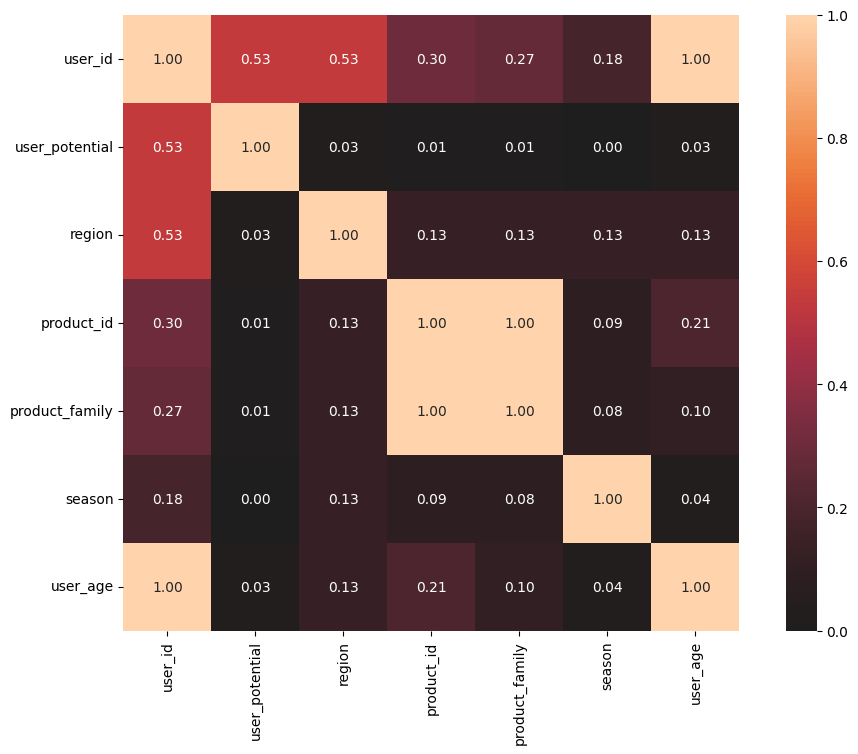

In [155]:
correlations = associations(labelled_df.loc[:, labelled_df.columns != "transaction_date"], numerical_columns= ["user_age"], figsize = (12, 8))

Aquí observamos algunas características de los datos que serán claves para las estratégias de entrenamiento de modelos predictivos:
- Por un lado, el `user_id` que parece ser un código hash está fuertemente correlacionado a `user_age` y también está correlacionado con las variables `user_potential` y `region`. Es natural que cada usuario solo tenga una edad, pero para usuarios que poseen múltiples entradas en distintos años en la base datos, parece no haber una regla para actualizar la edad de los usuarios a partir de la fecha de nacimiento/cumpleaños. Por otro lado, el hecho de que la id de usuario esté parcialmente correlacionado con la variable `user_potential` indica que para un mismo usuario esa cantidad puede variar, es decir que el hecho de crear más o menos entradas en la base datos le cambia su score. Mientras que la correlación parcial con la variable `region` indica que puede haber comprado en distintas regiones. Desde el punto de vista análitico, vamos a utilizar esta información para reducir la dimensionalidad de nuestro problema. 
- Las variables `user_potential`. `region`, `user_age` y `season` parecen no estar fuertemente correlacionadas a las demás variables del conjunto de datos. Para las tres primeras, eso indica una dependencia directa a cada usuario en concreto. Para la variable `season`, lo que notamos es que no hay estacionalidad en los registros respecto a los usuarios o los tipos de producto.
- Una fuerte correlación es observada para las variables `product_id` y `product_family`. Como esperado, cada producto pertenece a una familia en concreto. Lo que nos puede ayudar a reducir la cantidad de variables de nuestros modelos predictivos.

## Entendiendo los productos más populares y la posible existencia de estacionalidad

Ya hemos detectado que algunos productos son mucho más frecuentes que otros. Nos gustaría entender en el presente apartado cuáles son los productos más frecuentes en la base de datos y a qué `product_family` pertenencen. Además, podemos intentar inferir si hay clases de productos más frecuentes en distintas estaciones del año, a pesar del análisis de correlación del apartado anterior indicar lo contrario. 



### Productos más populares

In [132]:
data.groupby(by = ["product_id", "product_family"]).size()

product_id  product_family
1.0         family_A              0
            family_B              0
            family_C            902
2.0         family_A           5691
            family_B              0
            family_C              0
3.0         family_A          19397
            family_B              0
            family_C              0
4.0         family_A              0
            family_B            490
            family_C              0
5.0         family_A              0
            family_B            961
            family_C              0
dtype: int64

Esa tabla nos muestra que la `family_A` es la familia de productos más popular en la base de datos, siendo el producto 3.0 el más popular de todos. Un buen modelo predictivo tendrá como punto de referencia la varianza expresa en esa tabla.  

### Productos más populares por región

In [97]:
data.groupby(by = ["product_id", "region"]).size()

product_id  region  
1.0         Region A     108
            Region B     273
            Region C     344
            Region D     177
2.0         Region A    1818
            Region B    1672
            Region C     609
            Region D    1592
3.0         Region A    4710
            Region B    5658
            Region C    2322
            Region D    6707
4.0         Region A       4
            Region B     383
            Region C      33
            Region D      70
5.0         Region A     319
            Region B     300
            Region C      21
            Region D     321
dtype: int64

Una otra característica importante es que los productos más populares en toda la población son los menos populares en la región de interés de este proyecto (`Region C`). Vemos que los productos de la familia B tienen baja demanda en la `Region C`, mientras que el producto de la familia C encuentra más éxito en la región. La presente decisión nos puede ayudar a entrenar modelos predictivos para cada región, en el caso de que los modelos no sean capaces de capturar la varianza en los datos. 

### Estacionalidad por región y producto

In [156]:
data.groupby(by = ["season", "region"]).size()

season  region  
0       Region A    2431
        Region B    3430
        Region C    1987
        Region D    4183
1       Region A     290
        Region B     421
        Region C     326
        Region D     345
2       Region A     929
        Region B    1495
        Region C     440
        Region D     896
3       Region A    3309
        Region B    2940
        Region C     576
        Region D    3443
dtype: int64

Vemos que en la `Region C` la mayoría de las entradas se encuentran en la estación del año que comprende los meses de Diciembre, Enero y Febrero (`season = 0`). Podemos comprobar si esa frecuencia posee alguna correlación con algún producto en concreto. Comprobamos la proporción de productos por temporada respecto a los valores totales. 

In [165]:
data[data["region"] == 'Region C'].groupby(by = ["season", "product_id"]).size() / data[data["region"] == 'Region C'].groupby(by = ["product_id"]).size()

season  product_id
0       1.0           0.703488
        2.0           0.577997
        3.0           0.581826
        4.0           0.787879
        5.0           0.761905
1       1.0           0.072674
        2.0           0.118227
        3.0           0.098191
        4.0           0.030303
        5.0           0.000000
2       1.0           0.090116
        2.0           0.154351
        3.0           0.135228
        4.0           0.030303
        5.0           0.000000
3       1.0           0.133721
        2.0           0.149425
        3.0           0.184755
        4.0           0.151515
        5.0           0.238095
dtype: float64

Aquí notamos que la mayoría de las entradas para todos los productos en la `Region C` se encuentran en los meses de Diciembre, Enero y Febrero. Esa es una información que esperamos capturar en un modelo predictivo.

## Modelo predictivo

En este apartado, entrenamos un modelo para predecir las ventas en los próximos 4 trimestres. Este apartado se divide en: ingeniería de características, selección de modelos, entrenamiento del mejor modelo y discusión de los resultados.

### Ingeniería de características

En este apartado, extraemos y transformamos los datos disponibles para facilitar/posibilitar el proceso de entrenamiento del model predictivo. Lo primero que haremos es reducir la dimensionalidad de nuestro problema. Ya hemos comprobado que la variable `user_id` está correlacionada con otras tres variables que nos pueden ayudar a reducir la dimensión de nuestro problema. También podemos utilizar la variable `product_id`, en lugar de utilizar la variable `product_family`. También vamos a separar los conjuntos de datos de entrenamiento y validación/test.  